In [1]:
import pandas as pd
import matplotlib.pyplot as plt

ready_df = pd.read_csv('../ready_df.csv')
dummies_X = ready_df.drop(columns=['FraudFound_P'])
y = ready_df['FraudFound_P']

# Model creation

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, recall_score

from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool

from imblearn.ensemble import BalancedRandomForestClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import mlflow
import mlflow.sklearn
import os
from dotenv import load_dotenv

load_dotenv()

# needed like this for GCP connection to MLflow to work
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../my-creds.json'

tracking_uri = os.getenv('FRAUD_MODELLING_MLFLOW_TRACKING_URI')

# set_tracking_uri needs to be first
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment('Insurance Fraud Detection')

<Experiment: artifact_location='gs://fraud_modelling_artifacts/1', creation_time=1719982350461, experiment_id='1', last_update_time=1719982350461, lifecycle_stage='active', name='Insurance Fraud Detection', tags={}>

### Split dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dummies_X, y, test_size=0.2)

### Oversampling

In [5]:
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)

In [6]:
def cr_cm(y_true, y_pred):
    cr = classification_report(y_test, y_pred)
    print(cr)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## LogisticRegression no hyperparam search using oversampled data

In [7]:
import json

def save_feature_importance(model, model_name, X_test):
    if model_name == 'LogisticRegression':
        coefs = model.coef_[0].tolist() 
    else:
        coefs = model.feature_importances_.tolist()
    
    coefs = [float(value) for value in coefs]
    features = X_test.columns.tolist()
    feature_importance_dict = dict(zip(features, coefs))
    
    feature_importance_json = json.dumps(feature_importance_dict, indent=4)
    json_file_path = f"{model_name}_feature_importance.json"
    with open(json_file_path, "w") as json_file:
        json_file.write(feature_importance_json)
    
    mlflow.log_artifact(json_file_path, "model_report/")
    
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': coefs})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    feature_importance_png_path = f"{model_name}_feature_importance.png"
    plt.savefig(feature_importance_png_path)
    plt.close()
    mlflow.log_artifact(feature_importance_png_path, "model_report/")

def log_model_performance(model, X_test, y_test, model_name, model_description, best_params=None):
    with mlflow.start_run():
        mlflow.set_tag('model_name', model_name)
        mlflow.log_param('model_description', model_description)
        mlflow.sklearn.log_model(model, model_name)
        
        y_pred = model.predict(X_test)
        mlflow.log_metric('recall', recall_score(y_test, y_pred))
        
        save_feature_importance(model, model_name, X_test)
        
        classification_rep = classification_report(y_test, y_pred)
        mlflow.log_text(classification_rep, f"model_report/{model_name}_classification_report.txt")
        print("Classification Report:")
        print(classification_rep)
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix')
        plt.grid(False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        cm_img_path = f"{model_name}_confusion_matrix.png"
        plt.savefig(cm_img_path)
        plt.close()
        mlflow.log_artifact(cm_img_path, f"model_report/")
        
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        mlflow.log_metric("roc_auc_score", roc_auc)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        roc_curve_path = f"{model_name}_roc_curve.png"
        plt.savefig(roc_curve_path)
        plt.close()
        mlflow.log_artifact(roc_curve_path, f"model_report/")
        
        if best_params is not None:
            mlflow.log_params(best_params)

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_o, y_train_o)

y_pred = model.predict(X_test)

log_model_performance(model, X_test, y_test, 'LogisticRegression', 'Logistic Regression; No Hyperparameter Tuning; Using OverSampled data')
# cr_cm(y_test, y_pred)

KeyboardInterrupt: 

# XGBoost with hyperparam search using oversampled data

2024/07/03 14:45:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'be2ed4f428cf4269aa55a6e2d362264b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/07/03 14:45:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missi

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.9958592132505176
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      2905
           1       0.13      0.41      0.20       179

    accuracy                           0.81      3084
   macro avg       0.55      0.62      0.55      3084
weighted avg       0.91      0.81      0.85      3084



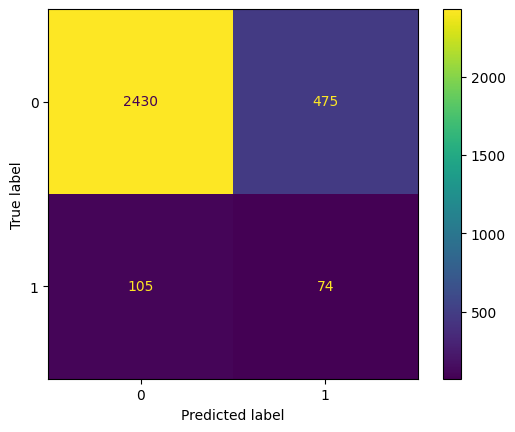

/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/03 14:45:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missin

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      2905
           1       0.13      0.41      0.20       179

    accuracy                           0.81      3084
   macro avg       0.55      0.62      0.55      3084
weighted avg       0.91      0.81      0.85      3084



2024/07/03 14:45:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


ROC AUC Score: 0.7678025750247598


In [48]:
model = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, verbose=0, n_jobs=-1, scoring='recall')

grid_search.fit(X_train_o, y_train_o)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(best_model, X_test, y_test, 'xgboost', 'XGBoost; Hyperparameter tuning; OverSampled data', grid_search.best_params_)

# LogisticRegression with hyperparam search using oversampled data

Best Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7566425120772947
              precision    recall  f1-score   support

           0       0.99      0.61      0.75      2905
           1       0.12      0.88      0.22       179

    accuracy                           0.63      3084
   macro avg       0.56      0.75      0.49      3084
weighted avg       0.94      0.63      0.72      3084



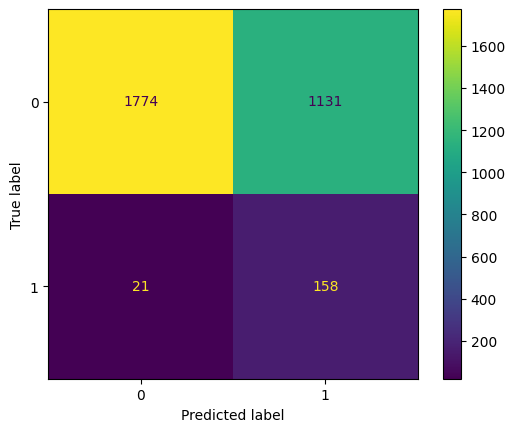

/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.75      2905
           1       0.12      0.88      0.22       179

    accuracy                           0.63      3084
   macro avg       0.56      0.75      0.49      3084
weighted avg       0.94      0.63      0.72      3084

ROC AUC Score: 0.7755891883575804


In [55]:
model = LogisticRegression(max_iter=1000)

param_grid = {
    'penalty': ['l1', 'l2'],           
    'C': [0.001, 0.01, 0.1, 1, 10],      
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, verbose=0, n_jobs=-1)

grid_search.fit(X_train_o, y_train_o)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(best_model, X_test, y_test, 'LogisticRegression', 'Logistic Regression; Hyperparameter tuning; OverSampled data', grid_search.best_params_)


# CatBoost no hyperparam search using oversampled data

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2905
           1       0.13      0.25      0.17       179

    accuracy                           0.86      3084
   macro avg       0.54      0.57      0.55      3084
weighted avg       0.90      0.86      0.88      3084



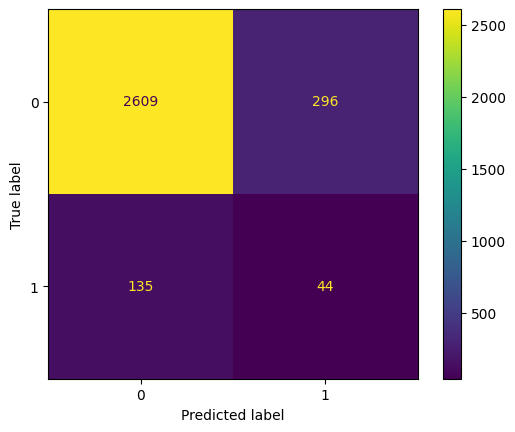

/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2905
           1       0.13      0.25      0.17       179

    accuracy                           0.86      3084
   macro avg       0.54      0.57      0.55      3084
weighted avg       0.90      0.86      0.88      3084

ROC AUC Score: 0.7725276204578891


In [57]:
params = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 16, 
    'loss_function': 'Logloss',
    'verbose': False 
}

train_pool = Pool(data=X_train_o, label=y_train_o)
test_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10, verbose_eval=False)

y_pred = model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(model, X_test, y_test, 'CatBoost', 'CatBoost; No Hyperparameter Tuning; OverSampled data', params)

# CatBoost no hyperparam search using NOT oversampled data

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2906
           1       1.00      0.02      0.04       178

    accuracy                           0.94      3084
   macro avg       0.97      0.51      0.51      3084
weighted avg       0.95      0.94      0.92      3084



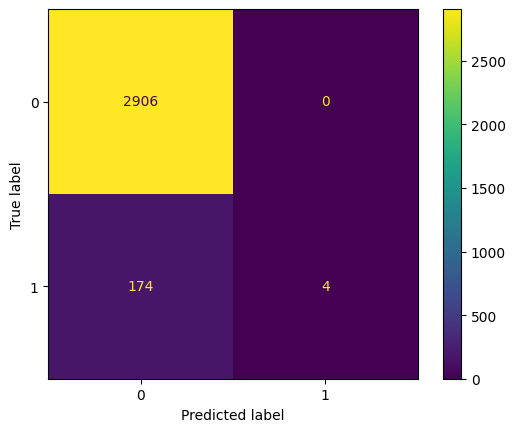

/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2906
           1       1.00      0.02      0.04       178

    accuracy                           0.94      3084
   macro avg       0.97      0.51      0.51      3084
weighted avg       0.95      0.94      0.92      3084

ROC AUC Score: 0.7986604622748749


In [49]:
params = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 16, 
    'loss_function': 'Logloss',
    'verbose': False 
}

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10, verbose_eval=False)

y_pred = model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(model, X_test, y_test, 'CatBoost', 'CatBoost; No Hyperparameter Tuning; No OverSampled data', params)

# Ensemble: XGB + RFClassifier with hyperparam search using NOT oversample data

# 

Best parameters found:  {'rf__max_depth': 7, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2906
           1       0.89      0.04      0.09       178

    accuracy                           0.94      3084
   macro avg       0.92      0.52      0.53      3084
weighted avg       0.94      0.94      0.92      3084



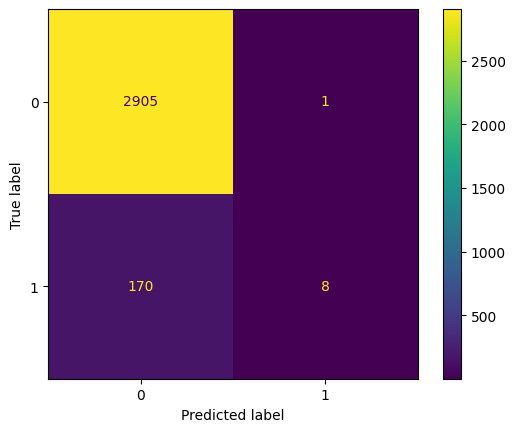

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2906
           1       0.89      0.04      0.09       178

    accuracy                           0.94      3084
   macro avg       0.92      0.52      0.53      3084
weighted avg       0.94      0.94      0.92      3084

ROC AUC Score: 0.7980592265518067


In [35]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,          
    max_depth=5,  
    learning_rate=0.1  
)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,   
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf)],
    voting='soft' 
)

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(best_model, X_test, y_test, 'XGB-RF VotingClassifier', 'Voting Classifier; Hyperparameter tuning; No OverSampled data', grid_search.best_params_)

# Ensemble: XGB + RFClassifier with hyperparam search using oversample data

Best parameters found:  {'rf__max_depth': 3, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Accuracy: 0.8073929961089494

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      2913
           1       0.15      0.52      0.23       171

    accuracy                           0.81      3084
   macro avg       0.56      0.67      0.56      3084
weighted avg       0.92      0.81      0.85      3084



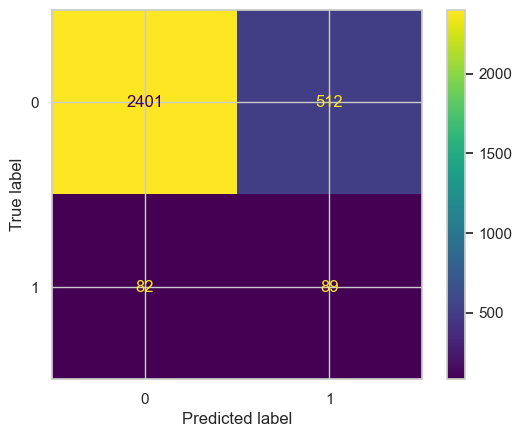

In [324]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,          
    max_depth=5,  
    learning_rate=0.1  
)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,   
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf)],
    voting='soft' 
)

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_o, y_train_o)

print("Best parameters found: ", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)
log_model_performance(best_model, X_test, y_test, 'XGB-RF VotingClassifier', 'Voting Classifier; Hyperparameter tuning; OverSampled data', grid_search.best_params_)

# BalancedRFClassifier no hyperparam search using NOT oversampled data

              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2906
           1       0.13      0.62      0.22       178

    accuracy                           0.74      3084
   macro avg       0.55      0.69      0.53      3084
weighted avg       0.92      0.74      0.81      3084



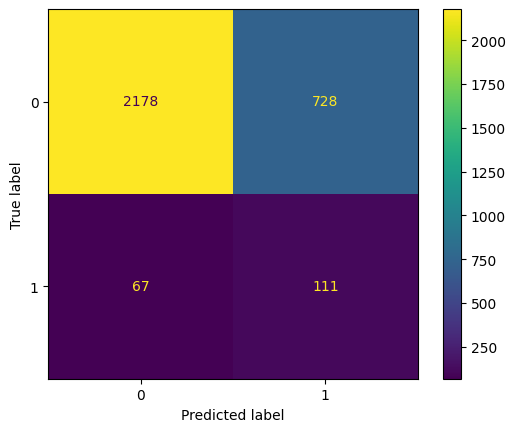

/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ivanivanov/miniconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2906
           1       0.13      0.62      0.22       178

    accuracy                           0.74      3084
   macro avg       0.55      0.69      0.53      3084
weighted avg       0.92      0.74      0.81      3084

ROC AUC Score: 0.7912126789207916


In [37]:
Bal_randForest = BalancedRandomForestClassifier(n_estimators=150, random_state=42, sampling_strategy='all', replacement=True, bootstrap=False)
balrandforest_model = Bal_randForest.fit(X_train,y_train)

y_pred_balforest = Bal_randForest.predict(X_test)

cr_cm(y_test, y_pred_balforest)

log_model_performance(balrandforest_model, X_test, y_test, 'BalancedRandomForest', 'Balanced Random Forest; No Hyperparameter Tuning; No OverSampled data')

# BalancedRFClassifier with param search using NOT oversampled data

Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150, 'sampling_strategy': 'not minority'}
              precision    recall  f1-score   support

           0       1.00      0.58      0.74      2904
           1       0.12      0.96      0.22       180

    accuracy                           0.61      3084
   macro avg       0.56      0.77      0.48      3084
weighted avg       0.94      0.61      0.71      3084



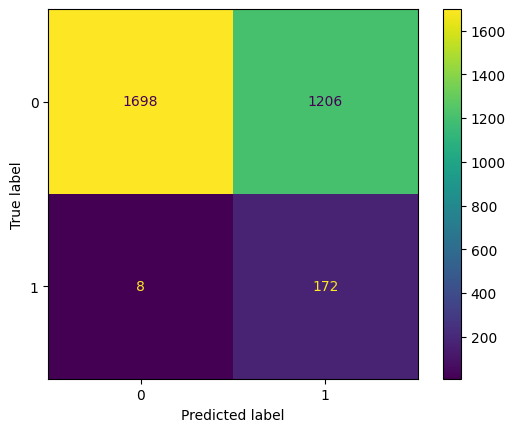

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.58      0.74      2904
           1       0.12      0.96      0.22       180

    accuracy                           0.61      3084
   macro avg       0.56      0.77      0.48      3084
weighted avg       0.94      0.61      0.71      3084

ROC AUC Score: 0.7962140342822162


In [8]:
Bal_randForest = BalancedRandomForestClassifier(n_estimators=150, replacement=True, bootstrap=False)
balrandforest_model = Bal_randForest.fit(X_train, y_train)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'sampling_strategy': ['auto', 'not minority', 'not majority']
}

grid_search = GridSearchCV(estimator=Bal_randForest, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

log_model_performance(best_model, X_test, y_test, 'BalancedRandomForest', 'Balanced Random Forest; Hyperparameter tuning; No OverSampled data', grid_search.best_params_)